In [83]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [84]:
train_data = pd.read_csv("train.csv")
total_train_class = len(train_data.iloc[:, 1].drop_duplicates(ignore_index=True))
total_train_class

176

In [85]:
test_list = train_data.iloc[:,1].drop_duplicates(ignore_index=True).apply(lambda x: x.split("_")).to_list()
test_arry = np.array(test_list)
split_type = pd.DataFrame((test_arry[:, 0], test_arry[:, 1])).T

In [86]:
split_type.drop_duplicates(subset=0)

,0,1
0,maclura,pomifera
1,ulmus,rubra
2,broussonettia,papyrifera
3,prunus,virginiana
4,acer,rubrum
...,...,...
162,halesia,tetraptera
164,evodia,daniellii
170,sassafras,albidum
172,ailanthus,altissima


In [87]:
split_type.drop_duplicates(subset=1) # the class type is really the type

,0,1
0,maclura,pomifera
1,ulmus,rubra
2,broussonettia,papyrifera
3,prunus,virginiana
4,acer,rubrum
...,...,...
170,sassafras,albidum
171,acer,griseum
172,ailanthus,altissima
173,pinus,thunbergii


In [89]:
# conver type name to type number, use the list
class_name_list = train_data.iloc[:,1].drop_duplicates(ignore_index=True).to_list()

# self define the get_position function, hash map maybe fast, but the data is very small, just use iter compare
def get_position(target, list):
    for index, item in enumerate(list):

        if target == item:
            
            return index
    return len(list) # this indicate the new type called other

train_data.iloc[:, 1] = train_data.iloc[:, 1].apply(get_position, args=(class_name_list,))

In [90]:
train_data

,image,label
0,images/0.jpg,0
1,images/1.jpg,0
2,images/2.jpg,0
3,images/3.jpg,0
4,images/4.jpg,0
...,...,...
18348,images/18348.jpg,107
18349,images/18349.jpg,75
18350,images/18350.jpg,133
18351,images/18351.jpg,73


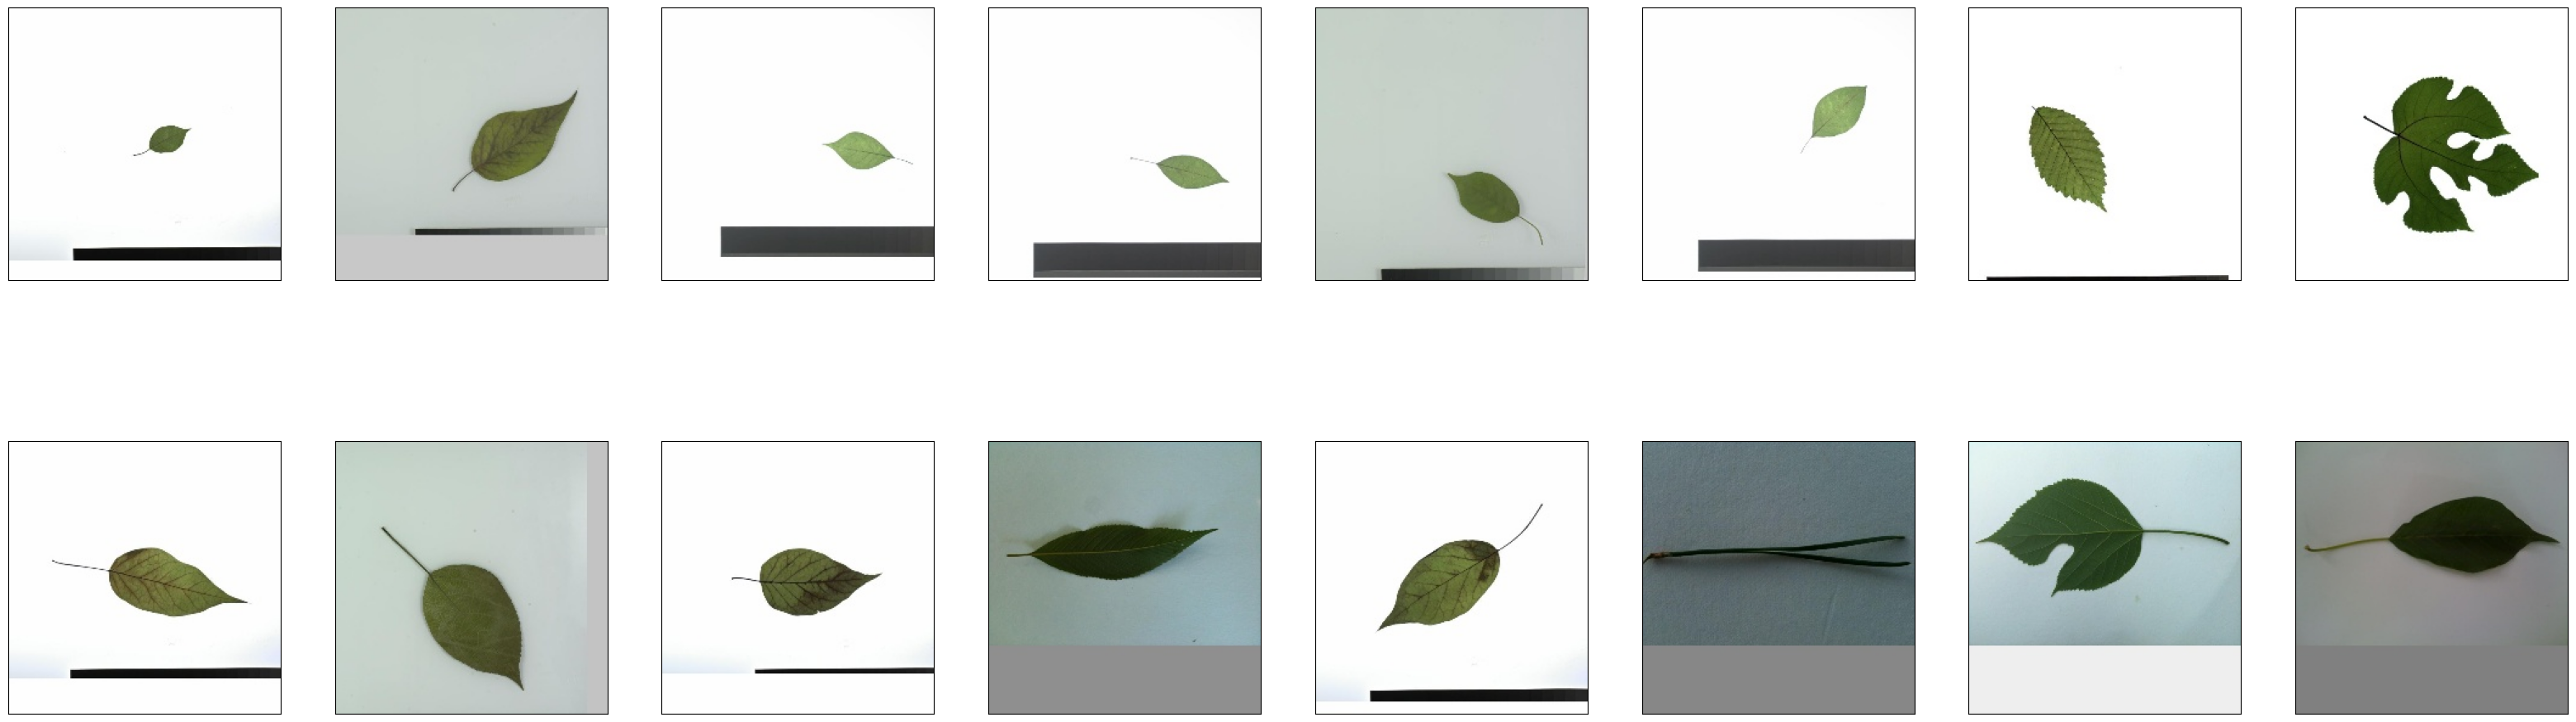

In [92]:
# check the same label data 

def plot_image(data_container, name_container, index, rows, columns):
    """print the image data from data_container
    """
    img_names = [name for name in data_container.iloc[index, 0].tolist()]
    imgs = [Image.open(img_name) for img_name in img_names]
    fig, axes = plt.subplots(rows, columns, figsize=(80/rows, 100/columns))
    axes = axes.flatten()
    plt.cla()
    for i, ax in enumerate(axes):
        ax.imshow(imgs[min(i, len(imgs)-1)])
        ax.set_xticks([])
        ax.set_yticks([])

plot_image(train_data, class_name_list, [i for i in range(200)], 2, 8)



In [76]:
class Leaves_Net(nn.Module):
    def __init__(self, num_of_class):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=3, padding=1, stride=1), nn.ReLU(),
            nn.Conv2d(20, 32, kernel_size=3, padding=1, stride=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # now the shape is (batchsize,32,112,112)
            nn.Dropout(p=0.6),
            nn.Conv2d(32, 40, kernel_size=1), nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(40, 52, kernel_size=3, padding=1, stride=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.7),
            nn.Conv2d(52, 60, kernel_size=1), nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(60, 80, kernel_size=5, padding=0, stride=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # current shape is 13x13x80
            nn.Conv2d(80, 80, kernel_size=7, padding=0, stride=1), nn.ReLU(),
        )
        self.block4 = nn.Sequential(
            nn.Flatten(), nn.Linear(7*7*80, 812), nn.ReLU(),
            nn.Linear(812, num_of_class), nn.ReLU()
        )

    def forward(self, X):
        X = self.block1(X)
        X = self.block2(X)
        X = self.block3(X)
        X = self.block4(X)
        return X

In [77]:
leaves_net = Leaves_Net(len(class_name_list))

In [78]:
class DataSet():
    def __init__(self, data_file, transforms=None, train=True, val_split=None):
        self.data_file = data_file
        self.transforms = transforms
        self.train = train
        self.val_split = val_split
        self.get_data_from_file()

    # self define the get_position function, hash map maybe fast, but the data is very small, just use iter compare
    def get_position(self, target, list):
        for index, item in enumerate(list):
            if target == item:
                return index
        return len(list) # this indicate the new type called other

    def get_data_from_file(self):
        """get the data from the specify data file
        """
        data_frame = pd.read_csv(self.data_file)
        # the test set don't have class
        if self.train:
            self.total_data_class = len(data_frame.iloc[:, 1].drop_duplicates(ignore_index=True)) # get the total class
            self.class_name_list = data_frame.iloc[:,1].drop_duplicates(ignore_index=True).to_list() # get the class name list
            data_frame.iloc[:, 1] = data_frame.iloc[:, 1].apply(self.get_position, args=(self.class_name_list,))
        self.data_frame = data_frame

    def __getitem__(self, index):
        img = Image.open(self.data_frame.iloc[index, 0])
        
        if self.transforms is not None:
            if not hasattr(self.transforms, "__len__"):
                transforms = [self.transforms]
            for transform in transforms:
                img = transform(img)
        if self.train:
            label = self.data_frame.iloc[index, 1]
            res = (img, label)
        else:
            res = (img, 0) # just for the dataloader
        return res

    def __len__(self):
        return len(self.data_frame)

In [79]:
def get_device():
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
        
    return torch.device(device)

device = get_device()
device

device(type='mps')

In [109]:
train_data = DataSet("train.csv", torchvision.transforms.ToTensor())
test_data = DataSet("test.csv", torchvision.transforms.ToTensor(), train=False)

# set the hypeter paramters including the batch_size 
batch_size = 64
epochs = 10
lr = 0.1


train_set, test_set= torch.utils.data.random_split(train_data, [0.8, 0.2])
train_loader, test_loader = DataLoader(train_set, batch_size=batch_size), DataLoader(test_set, batch_size=batch_size)

num_batches = len(train_set) // batch_size
 
for data in train_loader :
    imgs, targets = data
    print(imgs.shape)
    print(targets)
    break

torch.Size([64, 3, 224, 224])
tensor([ 14,  57,  48, 140,   0,  69, 117, 173,  61, 149,  35, 155, 102, 124,
          1, 109,  99, 124,  92,  10, 170,  15, 126,  36,  49,  98,  51, 124,
        104,  97,  47,  58,  26,  23, 121,  55,  73, 102,  88,  41,  15, 117,
         91,  51,  26,  76,  64, 115,   4,  46, 165, 137, 141,  29,   7,   9,
        101,  15,  55,  27,  62,  97, 135, 146])


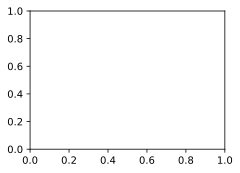

In [108]:
# define the loss function and optmizer
loss_fn = nn.CrossEntropyLoss().to(device)

updater = torch.optim.Adam(leaves_net.parameters())

leaves_net.to(device)

# use d2l acc and animator
metrics = d2l.Accumulator(3)
animator = d2l.Animator(xlim=(1, epochs), ylim=(1, 10), legend=["train_loss", "test_loss"])

In [118]:
for epoch in range(epochs):
    leaves_net.train()
    for i, (imgs, targets) in enumerate(train_loader):
        imgs, targets = imgs.to(device), targets.to(device)
        output = leaves_net(imgs)
        tmp_loss = loss_fn(output, targets)
        updater.zero_grad()
        tmp_loss.backward()
        updater.step()
        metrics.add(tmp_loss, 1)
        if (i+1) % (num_batches // 5) == 0 or (i == num_batches - 1):
            animator.add(epoch+1+i/num_batches, (metrics[0]/metrics[1], None))
    

    leaves_net.eval()
    total_num = 0
    total_loss = 0
    with torch.no_grad():
        for (imgs, targets) in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            output = leaves_net(imgs)
            tmp_loss = loss_fn(output, targets)
            total_loss = total_loss + tmp_loss
            total_num = total_num + 1
        animator.add(epoch, (None, total_loss / total_num))
            

KeyboardInterrupt: 